In [1]:
# Check Python executable path (useful for debugging environment issues)
import sys 
print(sys.executable)

c:\Users\junio\AppData\Local\Programs\Python\Python313\python.exe


In [2]:
# Core libraries for data manipulation and numerical operations
import numpy as np
import pandas as pd

# Financial data download
import yfinance as yf

# Machine learning preprocessing and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

# Deep learning framework for GRU model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import tensorflow as tf

# Visualization
import matplotlib.pyplot as plt

c:\Users\junio\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\junio\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\junio\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [3]:
# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

*FEATURE ENGINEERING*

In [4]:
# ============================================================================
# DATA DOWNLOAD AND PREPARATION
# ============================================================================
# Download 35 years of daily data for NASDAQ-100 index (^NDX)
df = yf.download("^NDX", period="35y", interval="1d")
df.attrs['ticker'] = "^NDX"  # Store ticker symbol for later reference

# Fix MultiIndex columns if yfinance returns them (flatten to single level)
df.columns = df.columns.get_level_values(0)

# Remove duplicate columns if any exist
df = df.loc[:, ~df.columns.duplicated()]

# ============================================================================
# TECHNICAL INDICATORS
# ============================================================================

# --- Moving Averages ---
# Simple Moving Averages: used to identify trends
# SMA_10: Short-term trend (10-day average)
# SMA_50: Medium-term trend (50-day average)
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# --- Log Returns ---
# Log returns are preferred over simple returns because:
# 1. They are symmetric (log(1/r) = -log(r))
# 2. They are approximately normally distributed for small changes
# 3. They are additive over time periods
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))

# --- Average True Range (ATR) ---
# ATR measures market volatility by calculating the average of true ranges over a period
# True Range is the maximum of: (High-Low), |High-PrevClose|, |Low-PrevClose|
atr_period = 14  # Standard 14-period ATR
true_range_high_low = df['High'] - df['Low']  # Current period range
true_range_high_close = (df['High'] - df['Close'].shift(1)).abs()  # Gap up from previous close
true_range_low_close = (df['Low'] - df['Close'].shift(1)).abs()  # Gap down from previous close
# Take maximum of all three to get true range
true_range = pd.concat([true_range_high_low, true_range_high_close, true_range_low_close], axis=1).max(axis=1)
# Normalize ATR by price to make it comparable across different price levels
df['ATR_14'] = (true_range.rolling(window=atr_period, min_periods=1).mean() / df['Close']).astype(float)

# --- Relative Strength Index (RSI) ---
# RSI is a momentum oscillator that measures speed and magnitude of price changes
# Values above 70 typically indicate overbought conditions, below 30 indicate oversold
rsi_period = 14  # Standard 14-period RSI
price_change = df['Close'].diff()  # Calculate price changes
gains = price_change.clip(lower=0)  # Only positive changes (gains)
losses = -price_change.clip(upper=0)  # Only negative changes (losses), made positive
avg_gains = gains.rolling(window=rsi_period, min_periods=1).mean()  # Average gains over period
avg_losses = losses.rolling(window=rsi_period, min_periods=1).mean()  # Average losses over period
rs = avg_gains / avg_losses.replace(0, np.nan)  # Relative strength ratio
# RSI formula: 100 - (100 / (1 + RS)), then normalized to 0-1 range for model input
df['RSI_14'] = (100 - (100 / (1 + rs))) / 100.0

# --- Volume Ratio ---
# Volume ratio compares current volume to average volume, indicating unusual trading activity
# High volume ratios often precede significant price movements
volume_sma_period = 20  # 20-day average volume
df['Vol_SMA_20'] = df['Volume'].rolling(window=volume_sma_period, min_periods=1).mean()
# Clip to 0-3 range to handle extreme volume spikes (winsorization)
df['Volume_Ratio'] = (df['Volume'] / df['Vol_SMA_20']).clip(lower=0, upper=3)

# --- Hurst Exponent ---
# Hurst exponent measures the long-term memory of a time series
# H < 0.5: Mean-reverting (anti-persistent)
# H = 0.5: Random walk (no memory)
# H > 0.5: Trending (persistent)
def calculate_hurst_exponent(ts, lags_range=range(2, 100)):
    """
    Calculate Hurst exponent using R/S (Rescaled Range) analysis.
    
    Args:
        ts: Time series data
        lags_range: Range of lag values to test
    
    Returns:
        Hurst exponent value (typically between 0 and 1)
    """
    lags = np.array(lags_range)
    # Calculate standard deviation of differences at each lag
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    # Fit power law: log(tau) = H * log(lags) + c
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0  # Multiply by 2 to get Hurst exponent

hurst_window = 250  # Use 250 trading days (~1 year) for Hurst calculation
hurst_values = []
# Calculate rolling Hurst exponent for each point in the dataset
for i in range(len(df)):
    if i < hurst_window:
        hurst_values.append(np.nan)  # Not enough data for early periods
    else:
        # Calculate Hurst for the window ending at current point
        hurst_values.append(calculate_hurst_exponent(df['Close'].values[i-hurst_window:i]))
df['Hurst'] = hurst_values

# ============================================================================
# FINAL CLEANUP
# ============================================================================
# Remove rows with NaN values (created by rolling calculations and shifts)
df.dropna(inplace=True)

C:\Users\junio\AppData\Local\Temp\ipykernel_31864\385117594.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^NDX", period="35y", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [5]:
# Define which columns to use as features for the model
# Includes raw OHLCV data plus all calculated technical indicators
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
                'SMA_10', 'SMA_50', 'ATR_14', 'RSI_14', 'Volume_Ratio', 'Hurst']


In [6]:
# ============================================================================
# DATA PREPROCESSING FUNCTION
# ============================================================================
def create_windows(features, targets, window_size):
    """
    Create sliding windows for time series data.
    
    For GRU models, we need sequences of historical data to predict the next value.
    This function creates overlapping windows where each window contains 'window_size'
    consecutive feature vectors, and the target is the value immediately after.
    
    Args:
        features: Array of feature vectors (shape: [n_samples, n_features])
        targets: Array of target values (shape: [n_samples,])
        window_size: Number of time steps to include in each window
    
    Returns:
        X: Windowed features (shape: [n_windows, window_size, n_features])
        y: Target values aligned with windows (shape: [n_windows,])
    
    Example:
        If window_size=3, features=[f1, f2, f3, f4, f5], targets=[t1, t2, t3, t4, t5]
        Returns: X=[[f1,f2,f3], [f2,f3,f4]], y=[t4, t5]
    """
    X, y = [], []
    for i in range(len(targets) - window_size):
        # Each window contains 'window_size' consecutive feature vectors
        X.append(features[i:i+window_size])
        # Target is the value 'window_size' steps ahead
        y.append(targets[i+window_size])
    return np.array(X), np.array(y)

*GRU Model Architecture*



=== Training up to 2007-07-01, testing on Global_Financial_Crisis (2007-07-01 → 2009-03-31) ===
Directional Accuracy: 55.85%
Global_Financial_Crisis | W:30 U:64 | PF:1.32 | DD:0.33%
RMSE: 0.0242 | MAE: 0.0173 | R2: -0.0068
Number of trades executed: 410


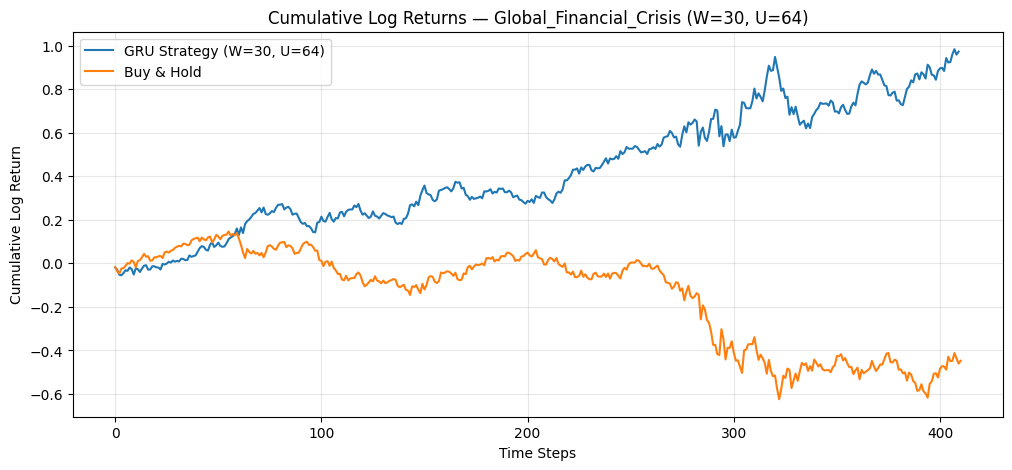

Directional Accuracy: 55.37%
Global_Financial_Crisis | W:30 U:128 | PF:1.27 | DD:0.29%
RMSE: 0.0246 | MAE: 0.0176 | R2: -0.0388
Number of trades executed: 410


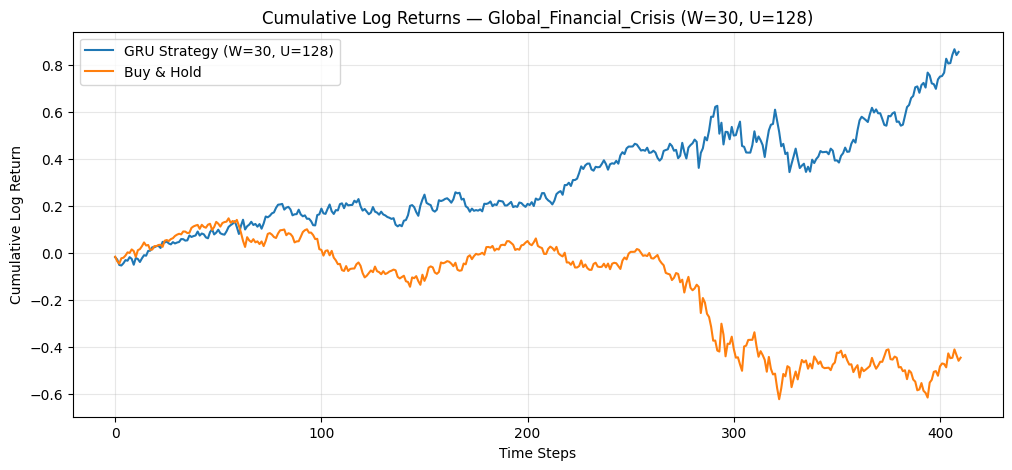

Directional Accuracy: 53.17%
Global_Financial_Crisis | W:30 U:256 | PF:1.15 | DD:0.35%
RMSE: 0.0244 | MAE: 0.0174 | R2: -0.0211
Number of trades executed: 410


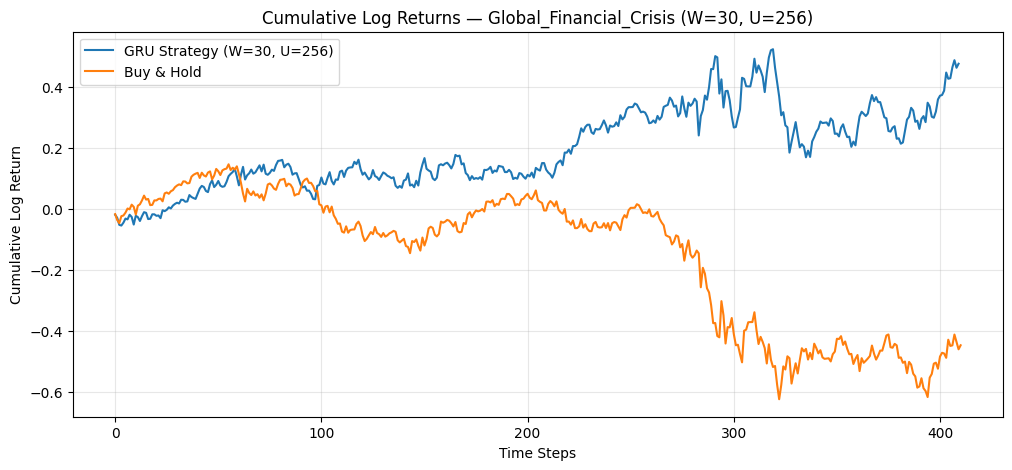

Directional Accuracy: 53.08%
Global_Financial_Crisis | W:50 U:64 | PF:1.18 | DD:0.42%
RMSE: 0.0246 | MAE: 0.0177 | R2: -0.0076
Number of trades executed: 390


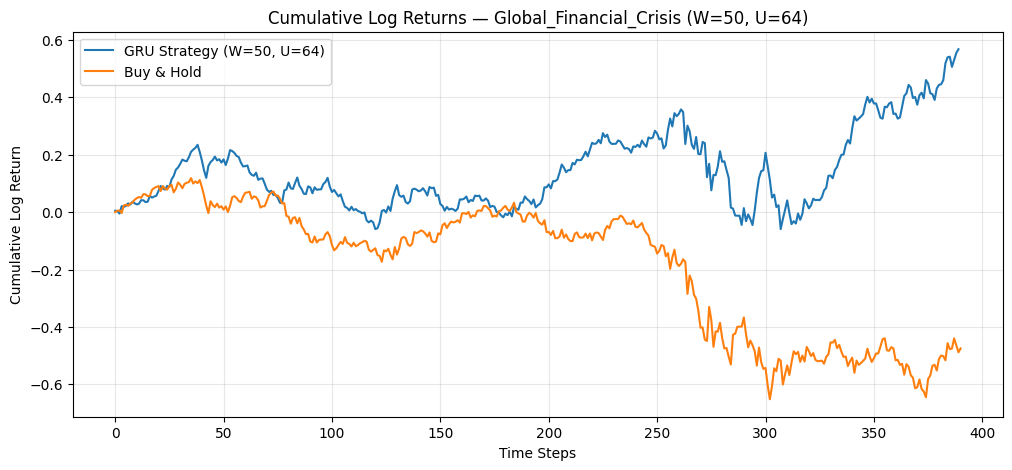

Directional Accuracy: 53.85%
Global_Financial_Crisis | W:50 U:128 | PF:1.33 | DD:0.23%
RMSE: 0.0249 | MAE: 0.0179 | R2: -0.0336
Number of trades executed: 390


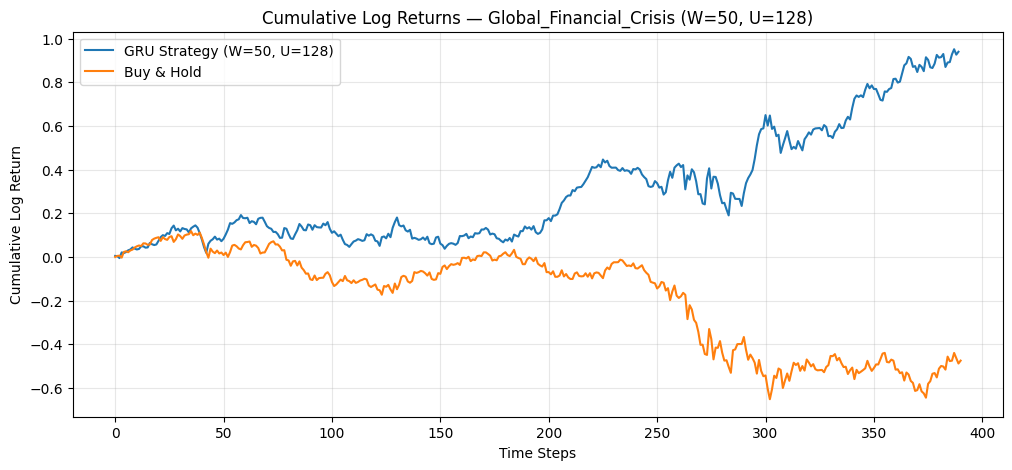

Directional Accuracy: 53.33%
Global_Financial_Crisis | W:50 U:256 | PF:1.22 | DD:0.31%
RMSE: 0.0247 | MAE: 0.0177 | R2: -0.0149
Number of trades executed: 390


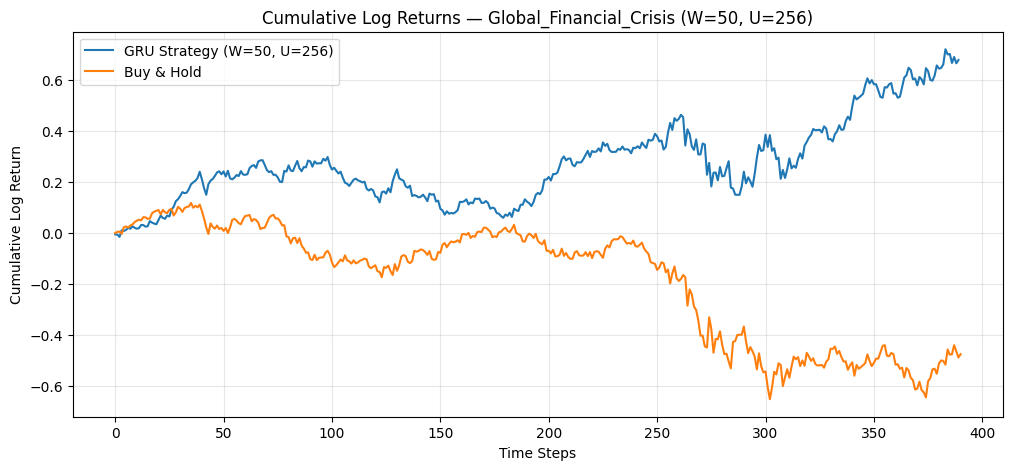

Directional Accuracy: 55.00%
Global_Financial_Crisis | W:100 U:64 | PF:1.13 | DD:0.47%
RMSE: 0.0259 | MAE: 0.0186 | R2: -0.0164
Number of trades executed: 340


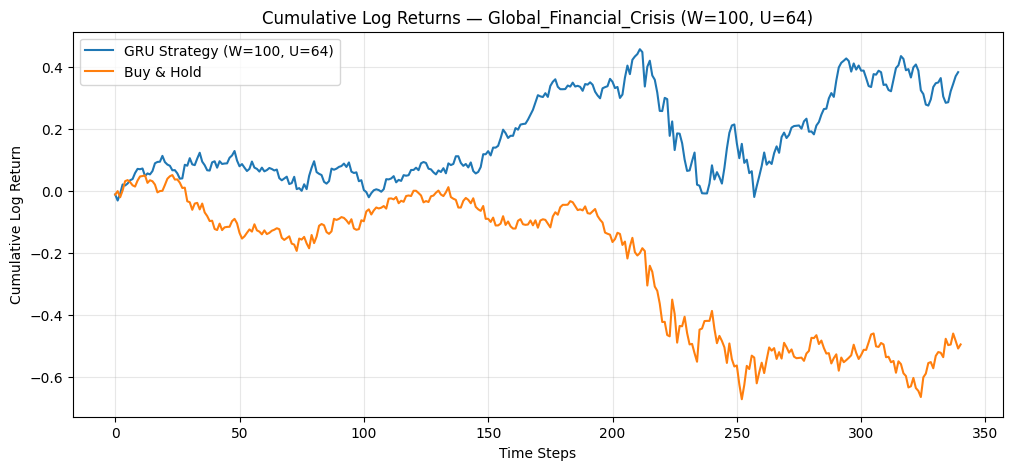

Directional Accuracy: 52.94%
Global_Financial_Crisis | W:100 U:128 | PF:1.22 | DD:0.28%
RMSE: 0.0258 | MAE: 0.0184 | R2: -0.0089
Number of trades executed: 340


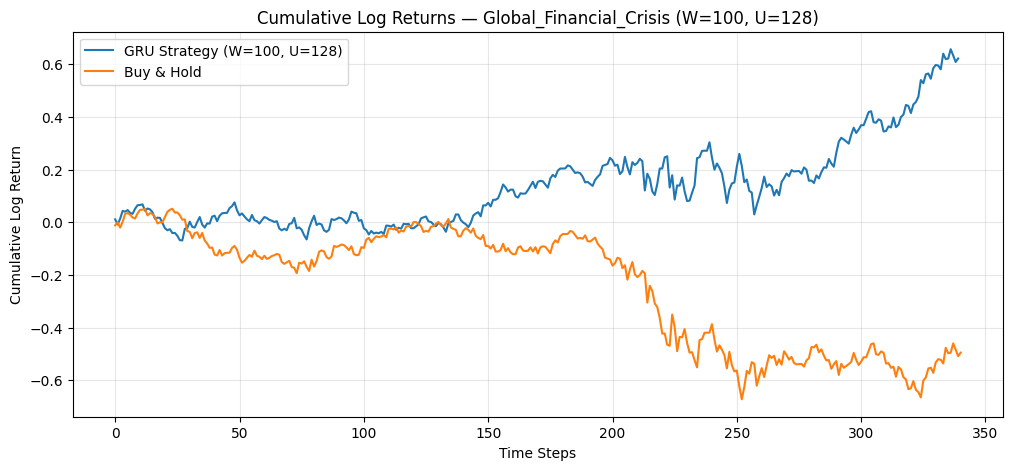

Skipping W=100, U=256 due to inf PF (no losing trades).

=== Training up to 2023-01-01, testing on AI_Boom (2023-01-01 → 2024-06-30) ===
Directional Accuracy: 51.60%
AI_Boom | W:30 U:64 | PF:0.96 | DD:0.21%
RMSE: 0.0105 | MAE: 0.0083 | R2: -0.0360
Number of trades executed: 343


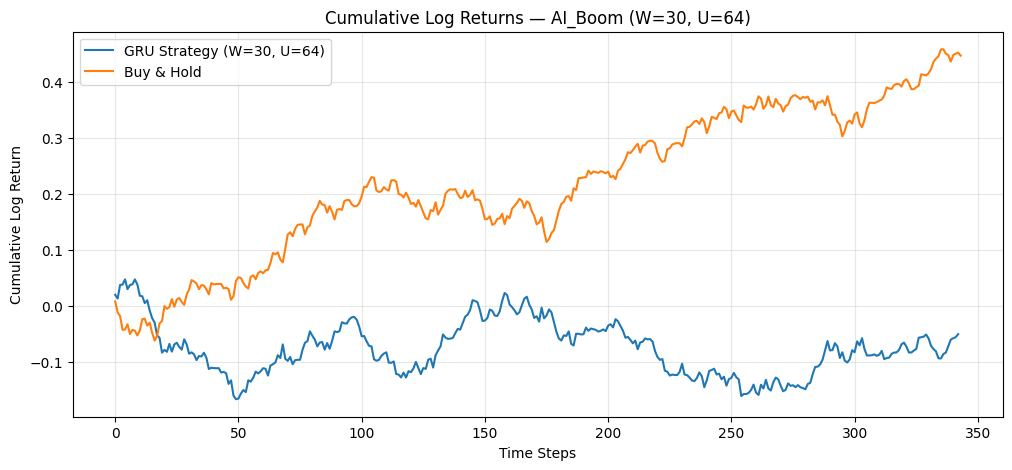

Directional Accuracy: 50.44%
AI_Boom | W:30 U:128 | PF:0.90 | DD:0.34%
RMSE: 0.0116 | MAE: 0.0093 | R2: -0.2588
Number of trades executed: 343


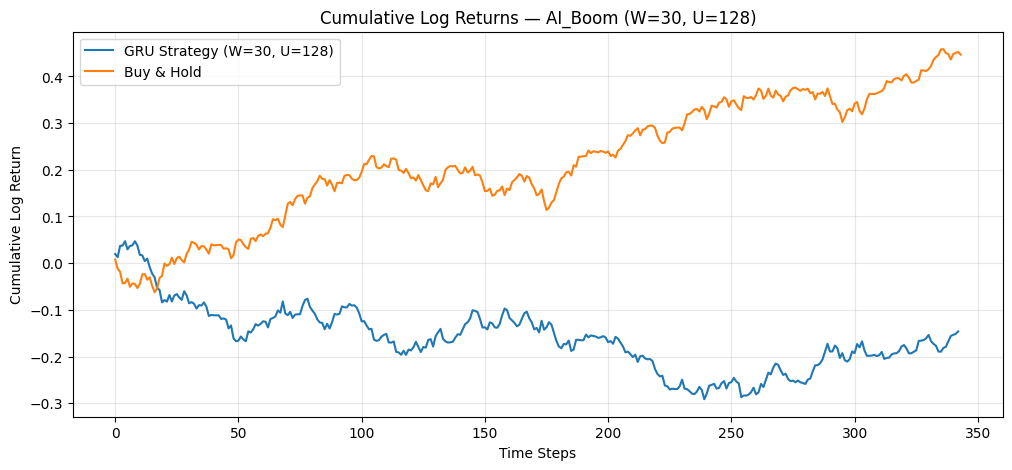

Directional Accuracy: 50.44%
AI_Boom | W:30 U:256 | PF:0.88 | DD:0.33%
RMSE: 0.0183 | MAE: 0.0159 | R2: -2.1352
Number of trades executed: 343


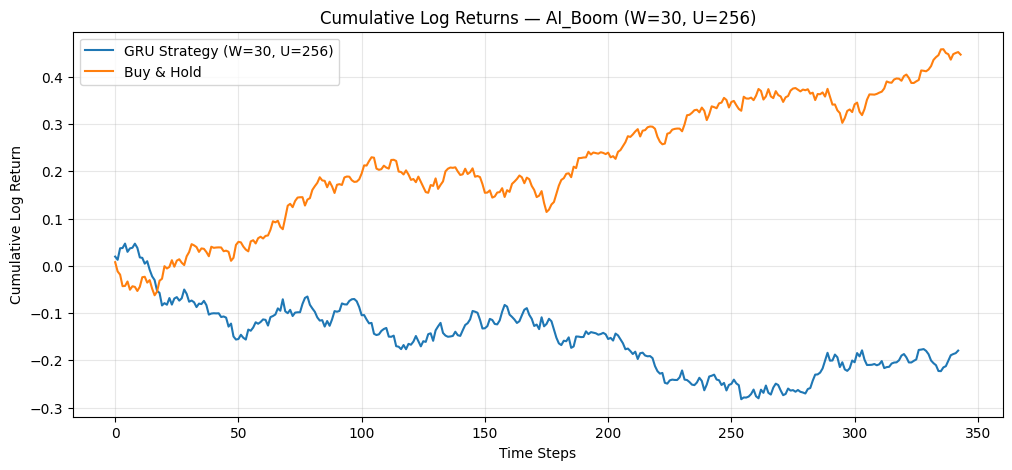

Directional Accuracy: 48.30%
AI_Boom | W:50 U:64 | PF:0.88 | DD:0.26%
RMSE: 0.0101 | MAE: 0.0078 | R2: 0.0018
Number of trades executed: 323


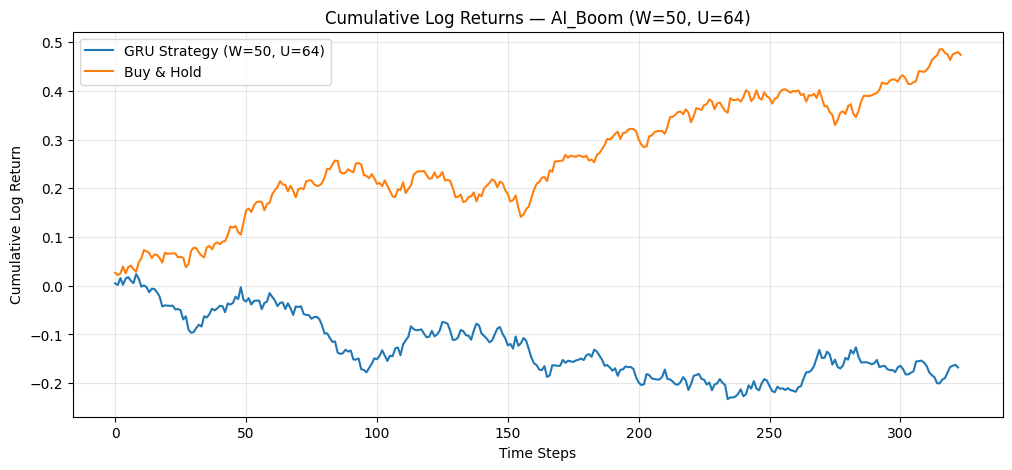

Directional Accuracy: 49.85%
AI_Boom | W:50 U:128 | PF:0.96 | DD:0.31%
RMSE: 0.0106 | MAE: 0.0083 | R2: -0.0875
Number of trades executed: 323


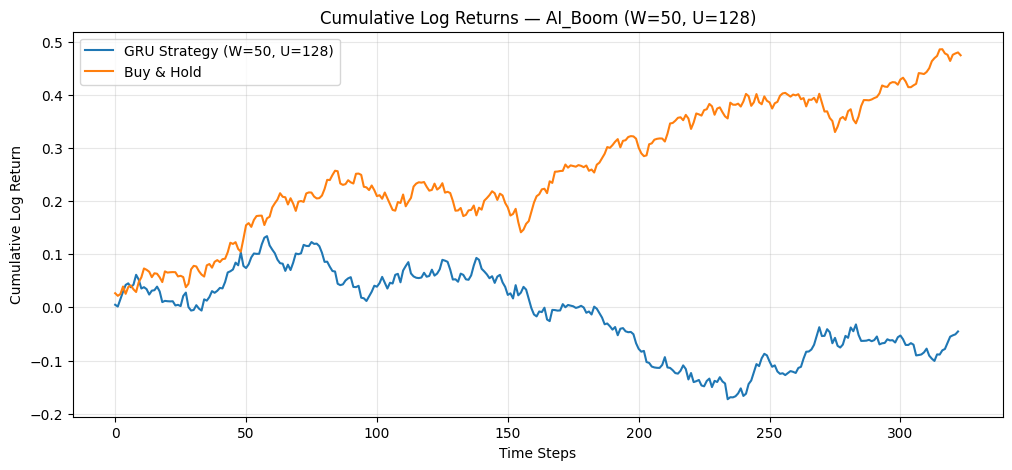

In [ ]:
# ============================================================================
# MARKET REGIME DEFINITIONS
# ============================================================================
# Define different market periods to test model performance across various conditions
# Each regime represents a distinct market environment (crashes, booms, etc.)
regimes = {
    # NASDAQ & S&P500 CRASH REGIMES (^NDX)
    # "Dotcom_Crash": ("2000-01-01", "2002-12-31"),  # Commented out - can be enabled
    "Global_Financial_Crisis": ("2007-07-01", "2009-03-31"),  # 2008 financial crisis
    "AI_Boom": ("2023-01-01", "2024-06-30"),  # Recent AI-driven market surge
}

# ============================================================================
# WALK-FORWARD ANALYSIS
# ============================================================================
# Container to store results for each regime and model configuration
regime_results = []

# Main walk-forward loop: train on data before each regime, test on the regime period
# This simulates real-world trading where we only use past data to predict future
for regime_name, (start_date, end_date) in regimes.items():
    print(f"\n=== Training up to {start_date}, testing on {regime_name} ({start_date} → {end_date}) ===")

    # ========================================================================
    # DATA SPLITTING
    # ========================================================================
    # Split data chronologically: train on all data before regime, test on regime period
    # This prevents look-ahead bias by ensuring test data comes after training data
    train_df = df.loc[:pd.to_datetime(start_date) - pd.Timedelta(days=1)].copy()
    test_df  = df.loc[start_date:end_date].copy()

    # Skip if insufficient data (need enough for training and meaningful testing)
    if len(train_df) < 200 or len(test_df) < 50:
        print(f"Skipping {regime_name} (insufficient data)")
        continue

    # ========================================================================
    # FEATURE SCALING
    # ========================================================================
    # CRITICAL: Fit scaler ONLY on training data to prevent data leakage
    # Then transform both train and test using the same scaler parameters
    scaler = MinMaxScaler()
    scaler.fit(train_df[feature_cols])  # Learn min/max from training data only
    
    # Scale features to [0, 1] range for neural network input
    train_scaled = scaler.transform(train_df[feature_cols])
    test_scaled  = scaler.transform(test_df[feature_cols])

    # Extract target values (log returns - already stationary, no scaling needed)
    train_returns = train_df['LogReturn'].values
    test_returns = test_df['LogReturn'].values

    # ========================================================================
    # HYPERPARAMETER GRID SEARCH
    # ========================================================================
    # Test multiple model configurations to find best hyperparameters
    # window_size: How many past time steps the model looks at
    # units: Number of GRU units (controls model capacity)
    for window_size in [30, 50, 100]:
        for units in [64, 128, 256]:
            # Create sliding windows for sequence data
            X_train, y_train = create_windows(train_scaled, train_returns, window_size)
            X_test, y_test = create_windows(test_scaled, test_returns, window_size)

            # Skip if no valid windows created
            if len(X_train) == 0 or len(X_test) == 0:
                continue

            # ====================================================================
            # MODEL ARCHITECTURE
            # ====================================================================
            # Build GRU (Gated Recurrent Unit) model for time series prediction
            # Architecture: Two GRU layers (first returns sequences, second returns single value)
            #               Followed by dense layers for final prediction
            model = Sequential([
                GRU(units, return_sequences=True),  # First GRU layer returns full sequence
                GRU(units//2),                       # Second GRU layer reduces to single value
                Dense(32, activation='relu'),        # Dense layer for non-linear transformation
                Dense(1)                             # Output layer: predicts next log return
            ])
            model.compile(optimizer='adam', loss='mse')  # Mean Squared Error for regression

            # Train model (verbose=0 suppresses training output)
            history = model.fit(X_train, y_train,
                                epochs=10, batch_size=32,
                                verbose=0)

            # ====================================================================
            # PREDICTIONS AND TRADING SIGNAL GENERATION
            # ====================================================================
            # Get model predictions (log returns) for test period
            real_preds = model.predict(X_test, verbose=0).flatten()
            real_actual = y_test  # Actual log returns for comparison

            if len(real_preds) < 2:
                continue

            # Generate trading signals based on predicted direction change
            # Strategy: Compare consecutive predictions to determine if trend is strengthening
            pred = real_preds[:-1]        # Current prediction
            next_pred = real_preds[1:]    # Next period's prediction

            # Position logic:
            # +1 = Long position (buy): if next prediction > current prediction (expecting rise)
            # -1 = Short position (sell): if next prediction < current prediction (expecting fall)
            #  0 = Flat position (no trade): if predictions are equal
            positions = np.zeros_like(pred)
            positions[next_pred > pred] = 1   # Go long if model expects higher returns
            positions[next_pred < pred] = -1  # Go short if model expects lower returns

            # ====================================================================
            # TRADING SIMULATION
            # ====================================================================
            # Align actual close prices with prediction horizon
            # Skip first 'window_size' prices (needed for initial window)
            actual_prices = test_df['Close'].values[int(window_size):]
            if len(actual_prices) < 2:
                continue
            entry = actual_prices[:-1]  # Entry price for each trade
            exit_ = actual_prices[1:]    # Exit price for each trade (next period)

            # Initialize trading simulation
            equity = 100_000  # Starting capital
            equity_curve = [equity]  # Track equity over time
            pnl_list = []  # Track profit/loss for each trade

            # Simulate trading based on generated positions
            for i in range(len(positions)):
                pos = positions[i]  # Current position: -1 (short), 0 (flat), or +1 (long)

                if pos == 0:
                    # No position – carry equity forward without change
                    equity_curve.append(equity)
                    continue

                # Risk management: risk 1% of current equity per trade
                trade_size = equity * 0.01

                if pos == 1:
                    # Long position: profit if price rises from entry to exit
                    pct_move = (exit_[i] - entry[i]) / entry[i]
                else:  # pos == -1
                    # Short position: profit if price falls from entry to exit
                    pct_move = (entry[i] - exit_[i]) / entry[i]

                # Calculate profit/loss for this trade
                trade_pnl = trade_size * pct_move
                equity += trade_pnl  # Update equity
                pnl_list.append(trade_pnl)  # Record trade P&L
                equity_curve.append(equity)  # Record equity after trade

            # ====================================================================
            # PERFORMANCE METRICS
            # ====================================================================
            # Calculate maximum drawdown: largest peak-to-trough decline in equity
            equity_curve = np.array(equity_curve)
            peaks = np.maximum.accumulate(equity_curve)  # Running maximum (peak equity)
            drawdowns = peaks - equity_curve  # Absolute drawdowns from peak
            drawdown_pcts = drawdowns / peaks  # Percentage drawdowns relative to each peak
            max_drawdown = np.max(drawdowns)  # Maximum drawdown in absolute terms
            max_drawdown_pct = np.max(drawdown_pcts)  # Maximum drawdown as percentage
            
            drawdown_pct = max_drawdown_pct  # Use percentage for results

            # Calculate profit factor: ratio of gross profit to gross loss
            # Profit Factor > 1 means strategy is profitable
            gross_profit = sum(p for p in pnl_list if p > 0)  # Sum of all winning trades
            gross_loss = -sum(p for p in pnl_list if p < 0)   # Sum of all losing trades (made positive)

            # Skip configurations with no losses (would result in infinite profit factor)
            if gross_loss == 0:
                print(f"Skipping W={window_size}, U={units} due to inf PF (no losing trades).")
                continue

            profit_factor = gross_profit / gross_loss  # Key performance metric

            # Count number of trades executed
            num_trades = len(pnl_list)

            # Filter out configurations with too few trades (likely overfitting or poor signal quality)
            # Require at least 25% of trading days to have active positions
            num_trading_days = len(positions)
            if num_trades < 0.25 * num_trading_days:
                print(f"Skipping W={window_size}, U={units} due to insufficient trades ({num_trades} < {0.25 * num_trading_days:.0f}).")
                continue
            
            # ====================================================================
            # RETURN ANALYSIS
            # ====================================================================
            # Calculate strategy returns: multiply position by actual next-period return
            # Long positions (+1) profit from positive returns, short positions (-1) profit from negative returns
            model_trade_logrets = []
            for i in range(len(positions)):
                pos = positions[i]
                if pos != 0 and i + 1 < len(real_actual):
                    # Strategy log return = position direction * actual next-day log return
                    model_trade_logrets.append(pos * real_actual[i+1])
                else:
                    model_trade_logrets.append(0.0)  # No position = zero return

            model_trade_logrets = np.array(model_trade_logrets)

            # Calculate cumulative returns for strategy and buy-and-hold
            model_cum_log_ret = np.cumsum(model_trade_logrets)  # Strategy cumulative returns
            asset_cum_log_ret = np.cumsum(real_actual)          # Buy & hold cumulative returns

            # ====================================================================
            # DIRECTIONAL ACCURACY
            # ====================================================================
            # Measure how often the model correctly predicts price direction
            # Only evaluated when model has an active position (not flat)
            positions_arr = np.array(positions)
            valid_mask = positions_arr != 0  # Only consider periods with active positions

            if valid_mask.sum() > 0:
                # Compare model's predicted direction (from position) with actual price direction
                asset_dir = np.sign(real_actual[1:len(positions_arr)+1])  # Actual direction
                model_dir = positions_arr[valid_mask]                      # Model's direction
                asset_dir_valid = asset_dir[valid_mask]
                directional_accuracy = np.mean(model_dir == asset_dir_valid)  # Percentage correct
            else:
                directional_accuracy = np.nan  # No positions to evaluate

            print(f"Directional Accuracy: {directional_accuracy:.2%}")

            # ====================================================================
            # PREDICTION ERROR METRICS
            # ====================================================================
            # Measure how well model predicts actual log returns (regression metrics)
            rmse = np.sqrt(mean_squared_error(real_actual, real_preds))  # Root Mean Squared Error
            mae = mean_absolute_error(real_actual, real_preds)           # Mean Absolute Error
            r2 = r2_score(real_actual, real_preds)                        # R-squared (coefficient of determination)

            print(f"{regime_name} | W:{window_size} U:{units} | PF:{profit_factor:.2f} | DD:{drawdown_pct:.2%}")
            
            # Print error metrics
            print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
            
            # Print numbers of trades  
            print(f"Number of trades executed: {num_trades}")
            
            # ====================================================================
            # VISUALIZATION
            # ====================================================================
            # Plot cumulative returns comparison: strategy vs buy-and-hold
            plt.style.use('default')
            plt.figure(figsize=(12,5))
            plt.plot(model_cum_log_ret, label=f"GRU Strategy (W={window_size}, U={units})")
            plt.plot(asset_cum_log_ret, label="Buy & Hold")
            plt.title(f"Cumulative Log Returns — {regime_name} (W={window_size}, U={units})")
            plt.xlabel("Time Steps")
            plt.ylabel("Cumulative Log Return")
            plt.legend()
            plt.grid(True, alpha=0.3)
            # Save plot with sanitized filename
            plot_name = f"{regime_name.replace('/','_').replace(' ','_')}_W{window_size}_U{units}_cumlogret.svg"
            plt.savefig(plot_name, format='svg')
            plt.show()
            
            # ====================================================================
            # STORE RESULTS
            # ====================================================================
            # Save all metrics for this configuration for later analysis
            regime_results.append({
                "Regime": regime_name,
                "Start": start_date,
                "End": end_date,
                "Window": window_size,
                "Units": units,
                "ProfitFactor": profit_factor,
                "MaxDrawdown": drawdown_pct,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "DirectionalAccuracy": directional_accuracy,
                "ModelCumLogRetEnd": float(model_cum_log_ret[-1]),
                "AssetCumLogRetEnd": float(asset_cum_log_ret[-1])
            })

# ============================================================================
# RESULTS SUMMARY
# ============================================================================
# Convert results to DataFrame and sort by regime, then by profit factor (descending)
# This allows easy identification of best performing models per regime
results_df = pd.DataFrame(regime_results).sort_values(["Regime", "ProfitFactor"], ascending=[True, False])


*Monte Carlo Permutation Test*


In [ ]:
def monte_carlo_permutation_pf(X_train, y_train, X_test, y_test, units, actual_prices,
                                num_permutations=50, epochs=3, use_simple_model=True):
    """
    Monte Carlo Permutation Test for statistical significance of trading strategy.
    
    This function tests whether the model's profit factor is statistically significant
    by comparing it against a null distribution where labels are randomly shuffled.
    If the real profit factor is significantly higher than random permutations,
    it suggests the model has genuine predictive power rather than just luck.
    
    Args:
        X_train: Training feature windows
        y_train: Training target values (log returns)
        X_test: Test feature windows
        y_test: Test target values (log returns)
        units: Number of GRU units in the model
        actual_prices: np.array of actual closing prices aligned with y_test (for P&L calculation)
        num_permutations: Number of random permutations to run (default: 50)
        epochs: Number of training epochs for each permutation (default: 3, reduced for speed)
        use_simple_model: If True, use smaller model (64 units max) for faster computation
    
    Returns:
        pf_list: List of profit factors from all permutations (null distribution)
    """
    from tensorflow.keras.callbacks import EarlyStopping
    
    pf_list = []  # Store profit factors from all permutations
    
    # Determine model complexity: use simpler model for speed if flag is set
    if use_simple_model:
        model_units = min(units, 64)  # Cap at 64 units for faster computation
    else:
        model_units = units  # Use full model complexity
    
    # Early stopping to prevent overfitting during permutation tests
    early_stop = EarlyStopping(monitor='loss', patience=2, restore_best_weights=False, verbose=0)
    
    print(f"Running {num_permutations} permutations (epochs={epochs}, units={model_units})...", end="", flush=True)

    # Run multiple permutations to build null distribution
    for perm_idx in range(num_permutations):
        if (perm_idx + 1) % 10 == 0:
            print(f" {perm_idx + 1}/{num_permutations}", end="", flush=True)

        # Step 1: Shuffle training labels to break any real relationships
        # This creates a null hypothesis where there's no predictive signal
        y_perm = np.random.permutation(y_train)

        # Step 2: Train model on permuted (randomized) data
        # Same architecture as real model, but trained on meaningless labels
        perm_model = Sequential([
                GRU(model_units, return_sequences=True),
                GRU(model_units//2),
                Dense(32, activation='relu'),
                Dense(1)
            ])
        perm_model.compile(optimizer='adam', loss='mse')
        perm_model.fit(X_train, y_perm, epochs=epochs, batch_size=32, 
                      callbacks=[early_stop], verbose=0)

        # Step 3: Generate predictions with permuted model
        perm_preds = perm_model.predict(X_test, verbose=0, batch_size=128).flatten()

        # Step 4: Apply same trading logic as real model
        # This tests if random predictions can generate similar profit factors
        entry = actual_prices[:-1]
        exit_ = actual_prices[1:]
        pred = perm_preds[:-1]
        next_pred = perm_preds[1:]

        # Generate positions using same logic as real model
        positions = np.zeros_like(pred)
        positions[next_pred > pred] = 1   # Long if expecting increase
        positions[next_pred < pred] = -1 # Short if expecting decrease

        # Simulate trading with same parameters as real model
        equity = 100_000
        pnl_list = []

        for i in range(len(positions)):
            pos = positions[i]
            if pos == 0:
                continue

            trade_size = equity * 0.01  # Same 1% risk per trade

            if pos == 1:
                # Long position
                pct_move = (exit_[i] - entry[i]) / entry[i]
            else:  # pos == -1
                # Short position
                pct_move = (entry[i] - exit_[i]) / entry[i]

            trade_pnl = trade_size * pct_move
            equity += trade_pnl
            pnl_list.append(trade_pnl)

        # Calculate profit factor for this permutation
        gross_profit = sum(p for p in pnl_list if p > 0)
        gross_loss = -sum(p for p in pnl_list if p < 0)
        pf = gross_profit / gross_loss if gross_loss > 0 else np.inf
        pf_list.append(pf)
        
        # Clean up model to free memory (important for many iterations)
        del perm_model
        tf.keras.backend.clear_session()

    print(" Done!")
    return pf_list


In [ ]:
# ============================================================================
# VISUALIZATION FUNCTION
# ============================================================================
def plot_mcpt_histogram(pf_distribution, real_pf, regime_name, window, units, p_value, mean_pf):
    """
    Plot histogram of Monte Carlo Permutation Test results.
    
    Visualizes the null distribution (from random permutations) and compares it
    to the real profit factor. If real PF is far to the right of the distribution,
    it suggests statistical significance.
    
    Args:
        pf_distribution: List of profit factors from permutations (null distribution)
        real_pf: Actual profit factor from real model
        regime_name: Name of market regime being tested
        window: Window size used in model
        units: Number of GRU units used in model
        p_value: Statistical p-value (proportion of permutations >= real_pf)
        mean_pf: Mean profit factor of null distribution
    """
    plt.style.use('default')
    pd.Series(pf_distribution).hist(color='blue', label='Permutations', bins=30)
    plt.axvline(real_pf, color='red', linestyle='--', linewidth=2, label=f'Real PF: {real_pf:.2f}')
    plt.axvline(mean_pf, color='black', linestyle='--', linewidth=2, label=f'Mean PF: {mean_pf:.2f}')
    plt.xlabel("Profit Factor", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title(f"MCPT: {regime_name} | W={window}, U={units} | P-Value: {p_value:.4f}", fontsize=13)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plot_name = f"{regime_name.replace('/','_').replace(' ','_')}_W{window}_U{units}_mcpt.svg"
    plt.savefig(plot_name, format='svg')
    plt.show()

In [ ]:
# === Monte Carlo Permutation Test Configuration ===
# Set to True to enable Monte Carlo testing (OPTIMIZED)
RUN_MONTE_CARLO = True  # Set to True to enable

# Options for Monte Carlo testing:
# - "all": Run on all model configurations (slower)
# - "best_per_regime": Run only on best model per regime (recommended)
# - "best_overall": Run only on overall best model (fastest)
MCPT_MODE = "best_per_regime"  # Options: "all", "best_per_regime", "best_overall"

# Monte Carlo test parameters (optimized for speed)
MCPT_NUM_PERMUTATIONS = 30  # 30-50 is usually sufficient
MCPT_EPOCHS = 3  # 3-5 is usually sufficient
MCPT_USE_SIMPLE_MODEL = False  # Use simpler model for permutation tests


Running OPTIMIZED Monte Carlo Permutation Tests

--- Testing best model for Dotcom_Crash ---
Config: W=100, U=128, PF=1.27
Running 30 permutations (epochs=3, units=128)...


 10/30 20/30 30/30 Done!
  MCPT Results: p-value = 0.0000
  Random PF distribution: 0.99 ± 0.10
   Statistically significant (p < 0.05)


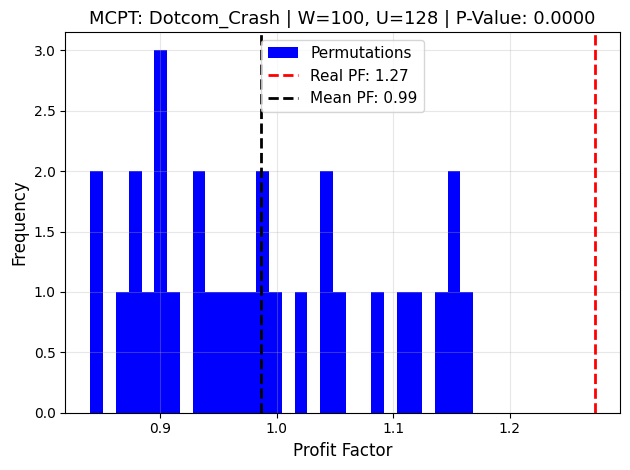

In [ ]:
# === Run Monte Carlo Permutation Test on Best Models (OPTIONAL) ===
# This runs the optimized MCPT only on the best models, saving significant time

if RUN_MONTE_CARLO and MCPT_MODE in ["best_per_regime", "best_overall"]:
    print("\n" + "="*60)
    print("Running OPTIMIZED Monte Carlo Permutation Tests")
    print("="*60)
    
    if MCPT_MODE == "best_per_regime":
        # Run MCPT on the best performing model for each regime separately
        # This tests statistical significance for each market condition independently
        for regime_name in regimes.keys():
            regime_best = results_df[results_df["Regime"] == regime_name].iloc[0]
            print(f"\n--- Testing best model for {regime_name} ---")
            print(f"Config: W={regime_best['Window']}, U={regime_best['Units']}, PF={regime_best['ProfitFactor']:.2f}")
            
            # Reconstruct the same data split and preprocessing used during training
            start_date, end_date = regimes[regime_name]
            train_df = df.loc[:pd.to_datetime(start_date) - pd.Timedelta(days=1)].copy()
            test_df = df.loc[start_date:end_date].copy()
            
            # Reapply same scaling (fit on train, transform both)
            scaler = MinMaxScaler()
            scaler.fit(train_df[feature_cols])
            train_scaled = scaler.transform(train_df[feature_cols])
            test_scaled = scaler.transform(test_df[feature_cols])
            
            # Extract returns and get best model's hyperparameters
            train_returns = train_df['LogReturn'].values
            test_returns = test_df['LogReturn'].values
            window = int(regime_best['Window'])  # Best window size for this regime
            units = int(regime_best['Units'])     # Best number of units for this regime
            
            # Create windows using best model's configuration
            X_train, y_train = create_windows(train_scaled, train_returns, window)
            X_test, y_test = create_windows(test_scaled, test_returns, window)
            actual_prices = test_df['Close'].values[window:]  # Prices aligned with predictions
            
            if len(X_test) == 0 or len(actual_prices) < 2:
                print("Skipping MCPT (insufficient samples)")
                continue
            
            pf_distribution = monte_carlo_permutation_pf(
                X_train, y_train, X_test, y_test,
                units,
                actual_prices,
                num_permutations=MCPT_NUM_PERMUTATIONS,
                epochs=MCPT_EPOCHS,
                use_simple_model=MCPT_USE_SIMPLE_MODEL
            )
            
            # Calculate p-value: proportion of permutations with PF >= real PF
            # Low p-value (< 0.05) means real PF is unlikely under null hypothesis (statistically significant)
            p_value = np.mean(np.array(pf_distribution) >= regime_best['ProfitFactor'])
            print(f"  MCPT Results: p-value = {p_value:.4f}")
            print(f"  Random PF distribution: {np.mean(pf_distribution):.2f} ± {np.std(pf_distribution):.2f}")
            print(f"  {' Statistically significant' if p_value < 0.05 else ' Not statistically significant'} (p < 0.05)")
            
            mean_pf = np.mean(pf_distribution)
            plot_mcpt_histogram(
                pf_distribution,
                regime_best['ProfitFactor'],
                regime_name,
                window,
                units,
                p_value,
                mean_pf  # Added parameter for mean PF
            )
    
    elif MCPT_MODE == "best_overall":
        # Run MCPT on the single best model across all regimes
        # This is faster but less comprehensive than testing each regime separately
        best_overall = results_df.iloc[0]  # First row is best (sorted by ProfitFactor descending)
        print(f"\n--- Testing overall best model ---")
        print(f"Regime: {best_overall['Regime']}")
        print(f"Config: W={best_overall['Window']}, U={best_overall['Units']}, PF={best_overall['ProfitFactor']:.2f}")
        
        start_date, end_date = regimes[best_overall['Regime']]
        train_df = df.loc[:pd.to_datetime(start_date) - pd.Timedelta(days=1)].copy()
        test_df = df.loc[start_date:end_date].copy()
        
        scaler = MinMaxScaler()
        scaler.fit(train_df[feature_cols])
        train_scaled = scaler.transform(train_df[feature_cols])
        test_scaled = scaler.transform(test_df[feature_cols])
        
        train_returns = train_df['LogReturn'].values
        test_returns = test_df['LogReturn'].values
        window = int(best_overall['Window'])
        units = int(best_overall['Units'])
        
        X_train, y_train = create_windows(train_scaled, train_returns, window)
        X_test, y_test = create_windows(test_scaled, test_returns, window)
        actual_prices = test_df['Close'].values[window:]
        
        if len(X_test) == 0 or len(actual_prices) < 2:
            print("Skipping MCPT (insufficient samples)")
        else:
            pf_distribution = monte_carlo_permutation_pf(
                X_train, y_train, X_test, y_test,
                units,
                actual_prices,
                num_permutations=MCPT_NUM_PERMUTATIONS,
                epochs=MCPT_EPOCHS,
                use_simple_model=MCPT_USE_SIMPLE_MODEL
            )
            
            p_value = np.mean(np.array(pf_distribution) >= best_overall['ProfitFactor'])
            print(f"  MCPT Results: p-value = {p_value:.4f}")
            print(f"  Random PF distribution: {np.mean(pf_distribution):.2f} ± {np.std(pf_distribution):.2f}")
            print(f"  {' Statistically significant' if p_value < 0.05 else ' Not statistically significant'} (p < 0.05)")
            
            mean_pf = np.mean(pf_distribution)
            plot_mcpt_histogram(
                pf_distribution,
                best_overall['ProfitFactor'],
                best_overall['Regime'],
                window,
                units,
                p_value,
                mean_pf  
            )
    
    print("\n" + "="*60)
else:
    print("\n Tip: Set RUN_MONTE_CARLO=True to enable Monte Carlo permutation testing")